# 4. Modelo: Clasificador BERT

Se busca predecir la rama del arbol de categorias(familia, categoria y sub-categoria) en la que se encuentra un producto dado.

### Enlaces

- [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](http://jalammar.github.io/illustrated-bert/)
- [Text Classification with BERT in PyTorch](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f)
- [Tutorial: Fine tuning BERT for Sentiment Analysis](https://skimai.com/fine-tuning-bert-for-sentiment-analysis/)
- [BERT models](https://huggingface.co/models)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy  as np
import pandas as pd

import torch
import transformers
from   torch import nn
from   torch.optim import Adam
    
import logging

from data.fashion import load_datasets
import data  as dt
import model as ml

import util  as ut
import pytorch_common.util as pu

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'1.12.1+cu116'

In [6]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-10-01 11:26:47,554 - INFO - cuda:0


In [7]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

## Funciones Helper

In [8]:
label_by_class = lambda df: {row['branch_seq']: row['branch'] for _, row in df[['branch_seq', 'branch']].drop_duplicates().iterrows() }

## Parametros

Fijamos la semilla para todas las librerias:

In [9]:
ut.set_seed(42)

Definimos el modelo preentrenado a utilizar. Este es una capa/module mas de nuestro modelo.

In [10]:
# MODEL_NAME ='bert-base-cased'
MODEL_NAME ='bert-base-uncased'
# MODEL_NAME = 'bert-large-uncased'
# MODEL_NAME ='distilbert-base-uncased'

Definimos los paths del dataset y pesos del modelo:

In [11]:
DATASET_PATH       = '../../datasets/fashion-outfits'
IMAGES_PATH        = '../../datasets/fashion-outfits/images'
WEIGHTS_PATH       = '../../weights'
CACHE_PATH         = '../../cache'
MODEL_WEIGHTS_PATH = f'{WEIGHTS_PATH}/{MODEL_NAME}.h5'

In [12]:
TRAIN = False

In [13]:
!mkdir -p {WEIGHTS_PATH}

## Cargar dataset

In [14]:
train_set, val_set, test_set = load_datasets(DATASET_PATH)

Tamaño máximo de la secuencia de entrada:

In [15]:
tokens_count = 2 + train_set['tokens_count'].max()
tokens_count

133

Definimos el tokenizer y los dataset para tran, validation y test:

In [16]:
tokenizer = ml.Tokenizer(
    tokenizer  = transformers.BertTokenizer.from_pretrained(MODEL_NAME), 
    padding    = 'max_length',
    max_length = tokens_count
)

In [17]:
train_dataset = dt.Dataset(train_set, feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)
val_dataset   = dt.Dataset(val_set,   feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)
test_dataset  = dt.Dataset(test_set,  feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)

## Preparando el modelo

Cantidad de clases a predecir:

In [18]:
len(train_set['branch_seq'].unique())

107

In [19]:
n_classes = train_set['branch_seq'].max() + 1
n_classes

107

In [20]:
classifier = ml.Classifier(
    transformer     = transformers.BertModel.from_pretrained(
        MODEL_NAME, 
        use_cache = True, 
        cache_dir = CACHE_PATH
    ),
    output_dim      = n_classes,
    dropout         = 0,
    hiden_state_dim = 768
)

## Entrenamiento

In [21]:
model = ml.ModelTrainer(classifier, batch_size = 50, criterion = nn.CrossEntropyLoss())

In [22]:
LR     = 0.00001
EPOCHS = 6

if TRAIN:
    model.fit(
        train_dataset, 
        val_dataset = val_dataset,
        optimizer   = Adam(classifier.parameters(), lr = LR),
        epochs      = EPOCHS
    )

In [23]:
if TRAIN:
    classifier.save(MODEL_WEIGHTS_PATH)

## Evaluación

In [24]:
classifier.load(MODEL_WEIGHTS_PATH)

In [25]:
summary = model.validate(test_dataset)
summary.show()

Accuracy: 85.66%, Loss: 0.009843


                                                      precision    recall  f1-score   support

                               accessories~belts~n/d       0.96      1.00      0.98        26
                                accessories~hats~n/d       0.98      1.00      0.99        50
                             accessories~scarves~n/d       1.00      1.00      1.00        48
                          accessories~sunglasses~n/d       1.00      1.00      1.00        40
activewear~performance trousers~performance leggings       1.00      0.75      0.86        24
                                  bags~backpacks~n/d       1.00      0.98      0.99        45
                                  bags~belt bags~n/d       0.98      0.96      0.97        49
                                bags~bucket bags~n/d       0.89      0.93      0.91        45
                                bags~clutch bags~n/d       0.98      0.89      0.93        55
                             bags~messenger bags~n/d       

<Figure size 2500x2500 with 2 Axes>

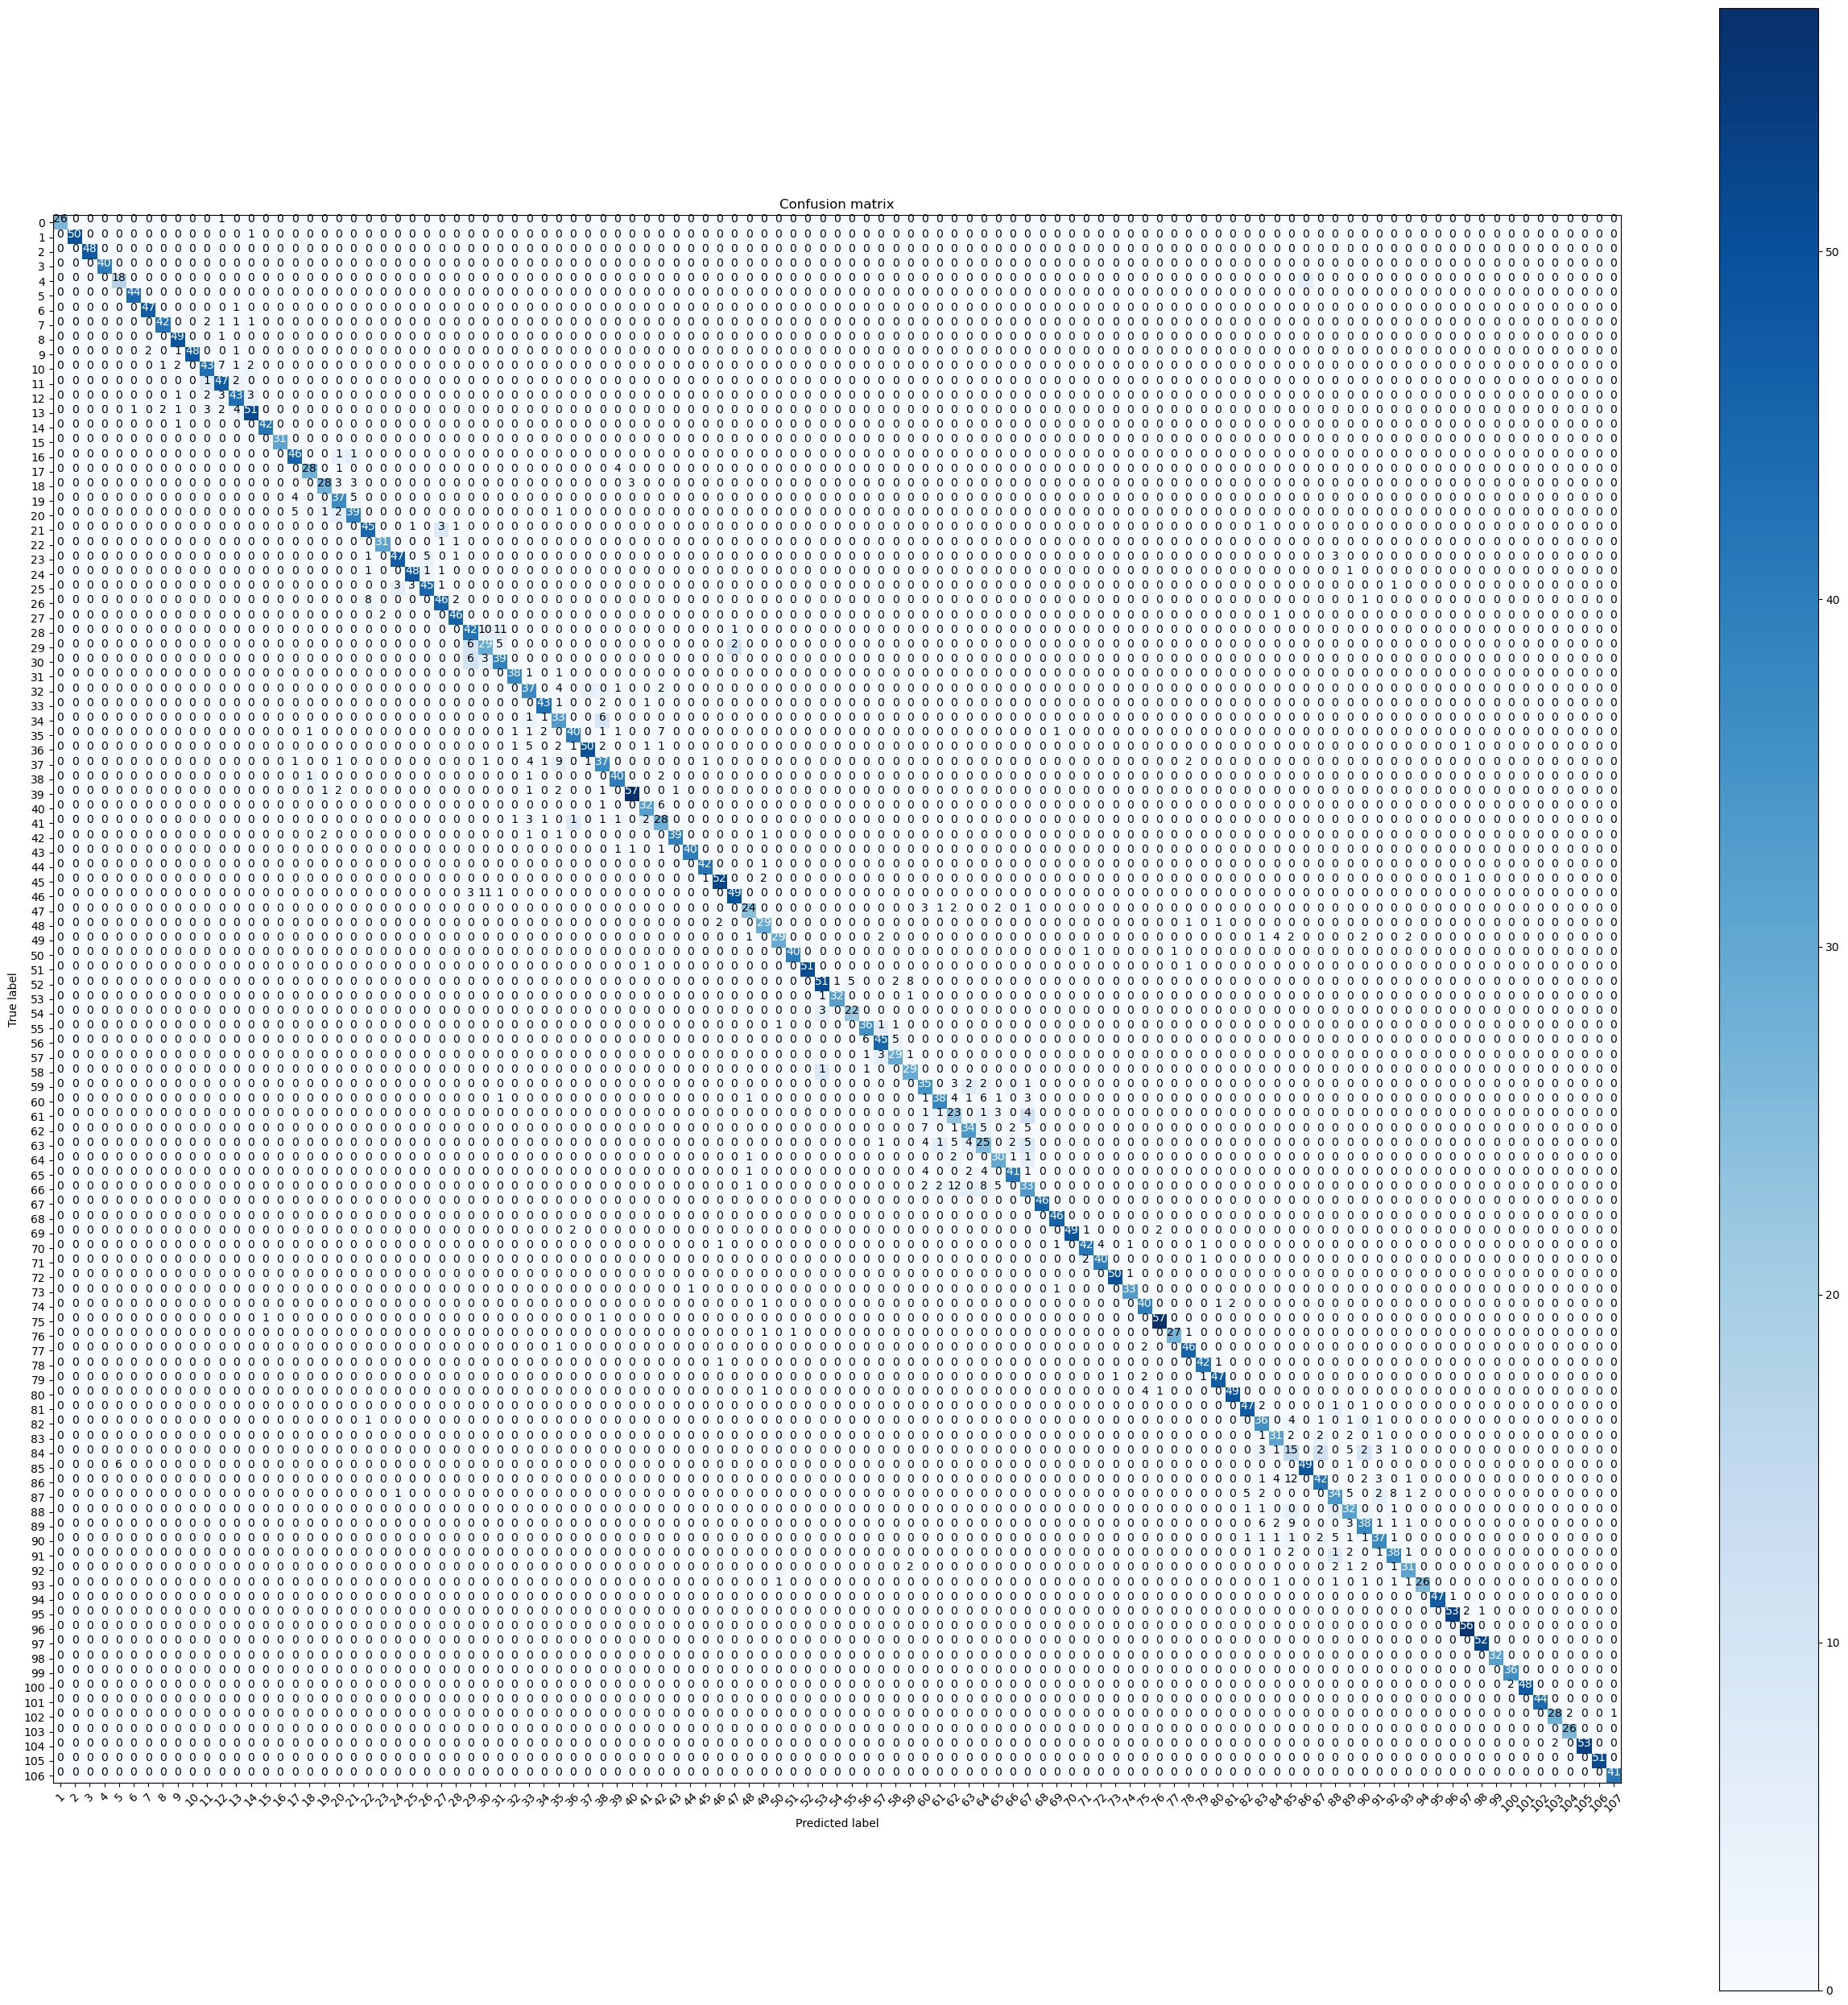

In [26]:
summary.plot_metrics(label_by_class = label_by_class(train_set))

In [27]:
report_generator = ml.FailReportGenerator(
    tokenizer, 
    test_set, 
    test_dataset, 
    summary.targets, 
    summary.predictions,
    IMAGES_PATH
)

report = report_generator()

report.to_csv(f'{DATASET_PATH}/bet-model-fail-report.csv', index=False)

Total Fails: 14.34%


Ahora filtramos el reporte solo para aquellas clases que tiene un F1Score menor al 69%:

In [28]:
worts_classes = [
    'clothing~coats~oversized coats',
    'clothing~coats~single breasted coats',
    'clothing~dresses~cocktail & party dresses',
    'clothing~dresses~day dresses',
    'clothing~dresses~evening dresses',
    'clothing~jackets~cropped jackets',
    'clothing~jackets~fitted jackets',
    'clothing~jackets~lightweight jackets',
    'clothing~jackets~oversized jackets',
    'clothing~jackets~sport jackets & windbreakers',
    'clothing~knitwear~knitted skirts',
    'clothing~shorts~knee-length shorts',
    'clothing~shorts~tailored shorts',
    'clothing~skirts~asymmetric & draped skirts',
    'clothing~skirts~fitted skirts',
    'clothing~skirts~full skirts',
    'clothing~skirts~high-waisted skirts',
    'clothing~skirts~pencil skirts',
    'clothing~skirts~straight skirts',
    'clothing~trousers~flared trousers',
    'clothing~trousers~high-waisted trousers',
    'clothing~trousers~regular & straight-leg trousers',
    'clothing~trousers~skinny trousers',
    'clothing~trousers~slim-fit trousers',
    'clothing~trousers~straight trousers'
]

report = report[report['true_class'].isin(worts_classes)].reset_index(drop=True)

In [29]:
report.shape, test_set.shape

((339, 5), (4944, 14))

In [30]:
ut.display_html(report.sample(frac=1).head(5))

,description,true_class,true_image,pred_class,pred_image
284,"description : baroque pattern - print bomber jacket. gender : women. brand : versace jeans couture. materials : polyester. highlights : multicolour, baroque - pattern print, front zip fastening, long sleeves, elasticated hem",clothing~jackets~fitted jackets,,clothing~jackets~bomber jackets,
116,"description : cut - out mini skirt. gender : women. brand : courreges. materials : cupro, polyurethane, spandex / elastane, cotton. highlights : black, mid - rise, snap - button fastening, cut - out detailing, straight hem, dart detailing",clothing~skirts~fitted skirts,,clothing~skirts~straight skirts,
113,"description : la robe ascua knitted dress. gender : women. brand : jacquemus. materials : wool, mohair, viscose, polyamide. highlights : green, mohair - wool blend, fine ribbed, twist detailing, crossover strap detail, off - shoulder, long sleeves",clothing~dresses~cocktail & party dresses,,clothing~knitwear~knitted dresses,
42,"description : high - waisted straight suede trousers. gender : women. brand : brunello cucinelli. materials : acetate, leather, polyester, cupro. highlights : brown, leather, high waist, drawstring waist, straight leg, two side welt pockets",clothing~trousers~high-waisted trousers,,clothing~trousers~straight trousers,
126,"description : high - waisted zip - detail trousers. gender : women. brand : opening ceremony. materials : cotton, polyester. highlights : mint green, cotton, zip details, high waist, belt loops, front button and zip fastening, two side inset pockets",clothing~trousers~slim-fit trousers,,clothing~trousers~high-waisted trousers,


In [31]:
branch_by_seq = {r['branch_seq']: r['branch'] for _, r in train_set[['branch_seq', 'branch']].drop_duplicates().iterrows()}

branch_predictions = [branch_by_seq[e] for e in np.concatenate(summary.predictions)]
branch_targets     = [branch_by_seq[e] for e in np.concatenate(summary.targets)]

family_predictions = [e.split('~')[0] for e in branch_predictions]
family_targets     = [e.split('~')[0] for e in branch_targets]

category_predictions = [e.split('~')[1] for e in branch_predictions]
category_targets     = [e.split('~')[1] for e in branch_targets]

subcategory_predictions = [e.split('~')[2] for e in branch_predictions]
subcategory_targets     = [e.split('~')[2] for e in branch_targets]

              precision    recall  f1-score   support

 accessories       0.99      1.00      0.99       164
  activewear       1.00      0.75      0.86        24
        bags       1.00      0.99      1.00       466
    clothing       1.00      1.00      1.00      3710
   jewellery       1.00      0.99      1.00       214
   pre-owned       1.00      1.00      1.00       118
       shoes       1.00      1.00      1.00       248

    accuracy                           1.00      4944
   macro avg       1.00      0.96      0.98      4944
weighted avg       1.00      1.00      1.00      4944



<Figure size 400x400 with 2 Axes>

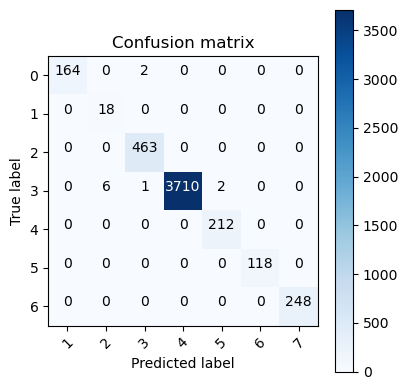

In [32]:
ml.plot_metrics(family_targets, family_predictions, figuresize=(4, 4))

                            precision    recall  f1-score   support

                all in one       0.98      0.98      0.98        43
                 backpacks       1.00      0.98      0.99        45
                 beachwear       1.00      1.00      1.00        31
                 belt bags       0.98      0.96      0.97        49
                     belts       0.96      1.00      0.98        26
                     boots       1.00      1.00      1.00        44
                 bracelets       0.98      1.00      0.99        47
               bucket bags       0.89      0.93      0.91        45
               clutch bags       0.98      0.89      0.93        55
                     coats       0.96      0.96      0.96       213
                     denim       0.98      0.99      0.99       346
                   dresses       0.98      0.92      0.95       200
                  earrings       0.95      0.98      0.96        54
                      hats       0.98      1.00

<Figure size 1500x1500 with 2 Axes>

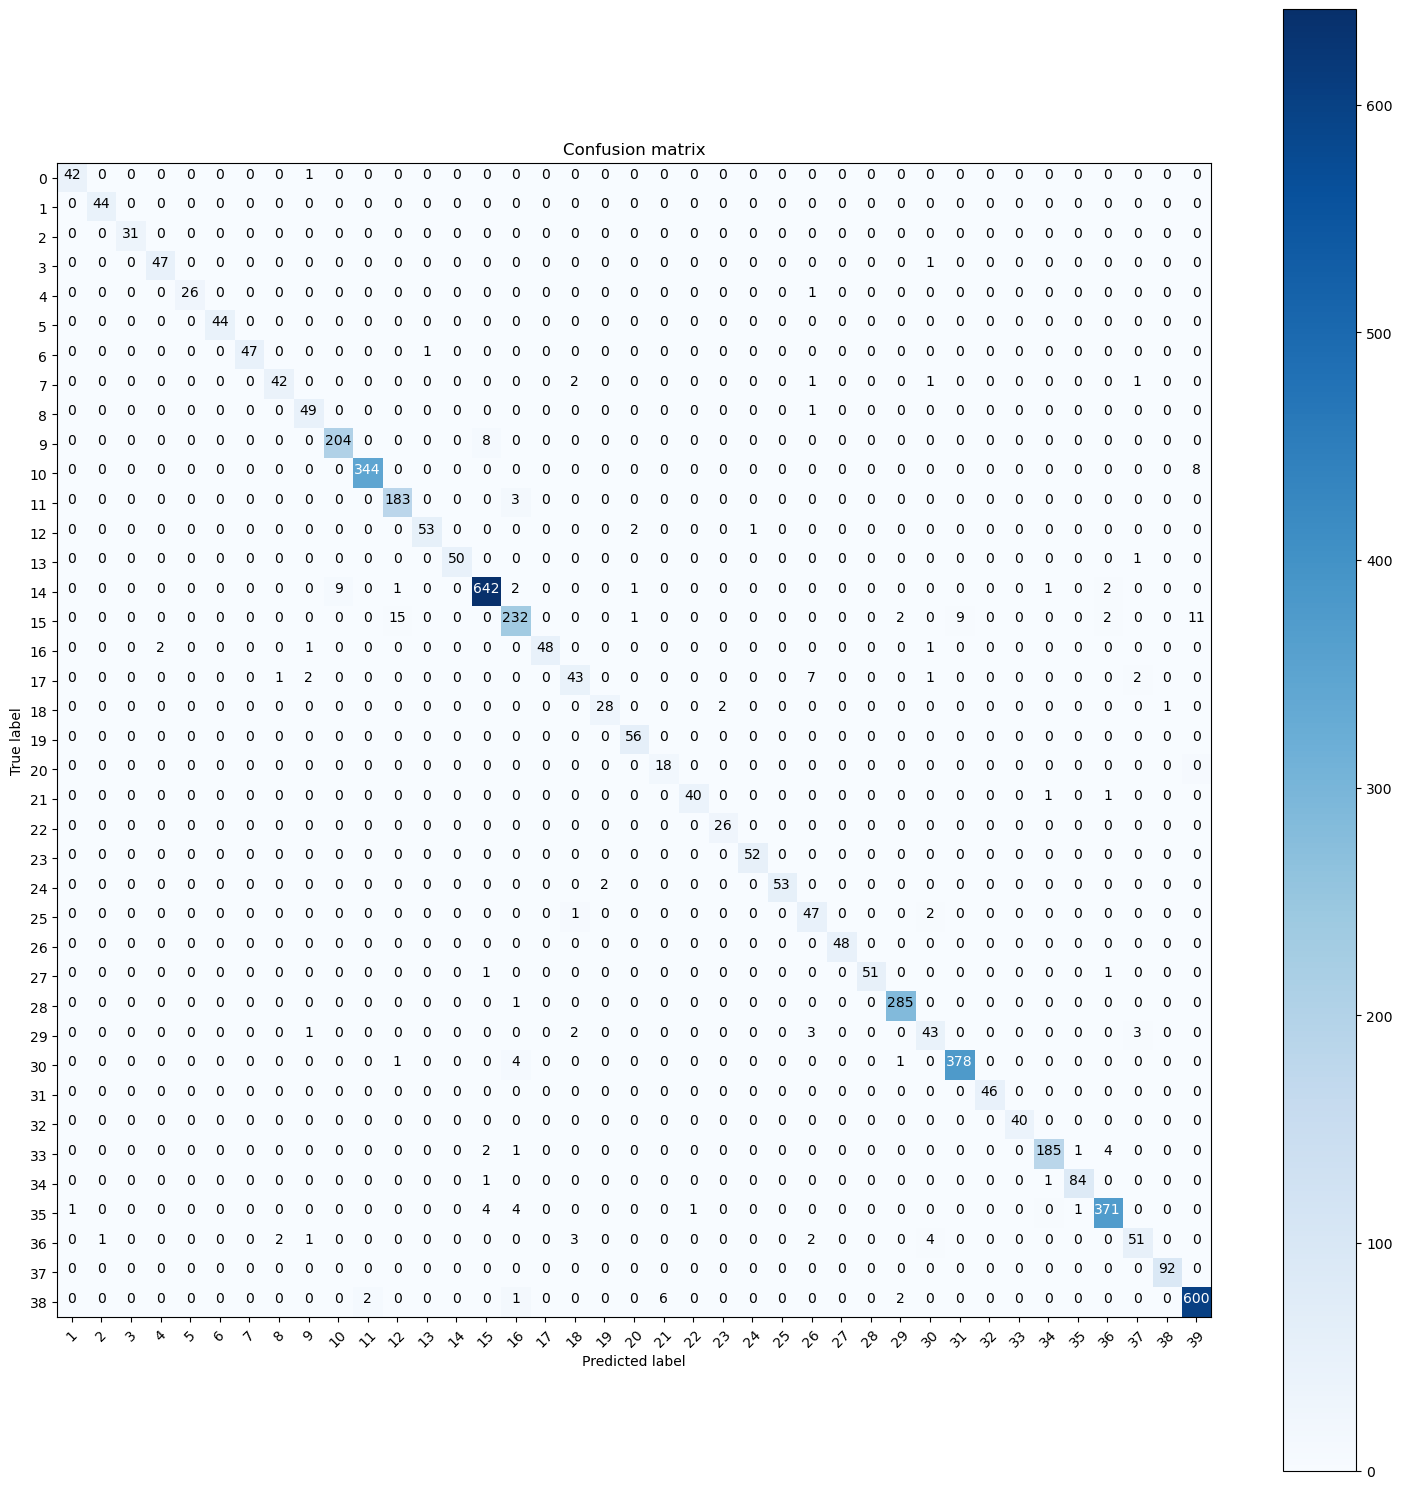

In [33]:
ml.plot_metrics(category_targets, category_predictions, figuresize=(15, 15))

                                 precision    recall  f1-score   support

                  a-line skirts       0.81      0.61      0.70        57
     asymmetric & draped skirts       0.68      0.88      0.77        43
                 bermuda shorts       0.76      0.91      0.83        56
                        bikinis       1.00      1.00      1.00        31
                        blazers       0.95      0.93      0.94        41
                        blouses       0.91      0.83      0.87        48
                 bomber jackets       0.84      0.67      0.75        55
                      cardigans       0.99      0.95      0.97        93
                   cargo shorts       0.94      0.97      0.96        33
                   chino shorts       0.88      0.81      0.85        27
                         chinos       0.92      0.87      0.90        54
       cocktail & party dresses       0.66      0.74      0.69        57
                  cropped jeans       0.88      0.

<Figure size 2400x2400 with 2 Axes>

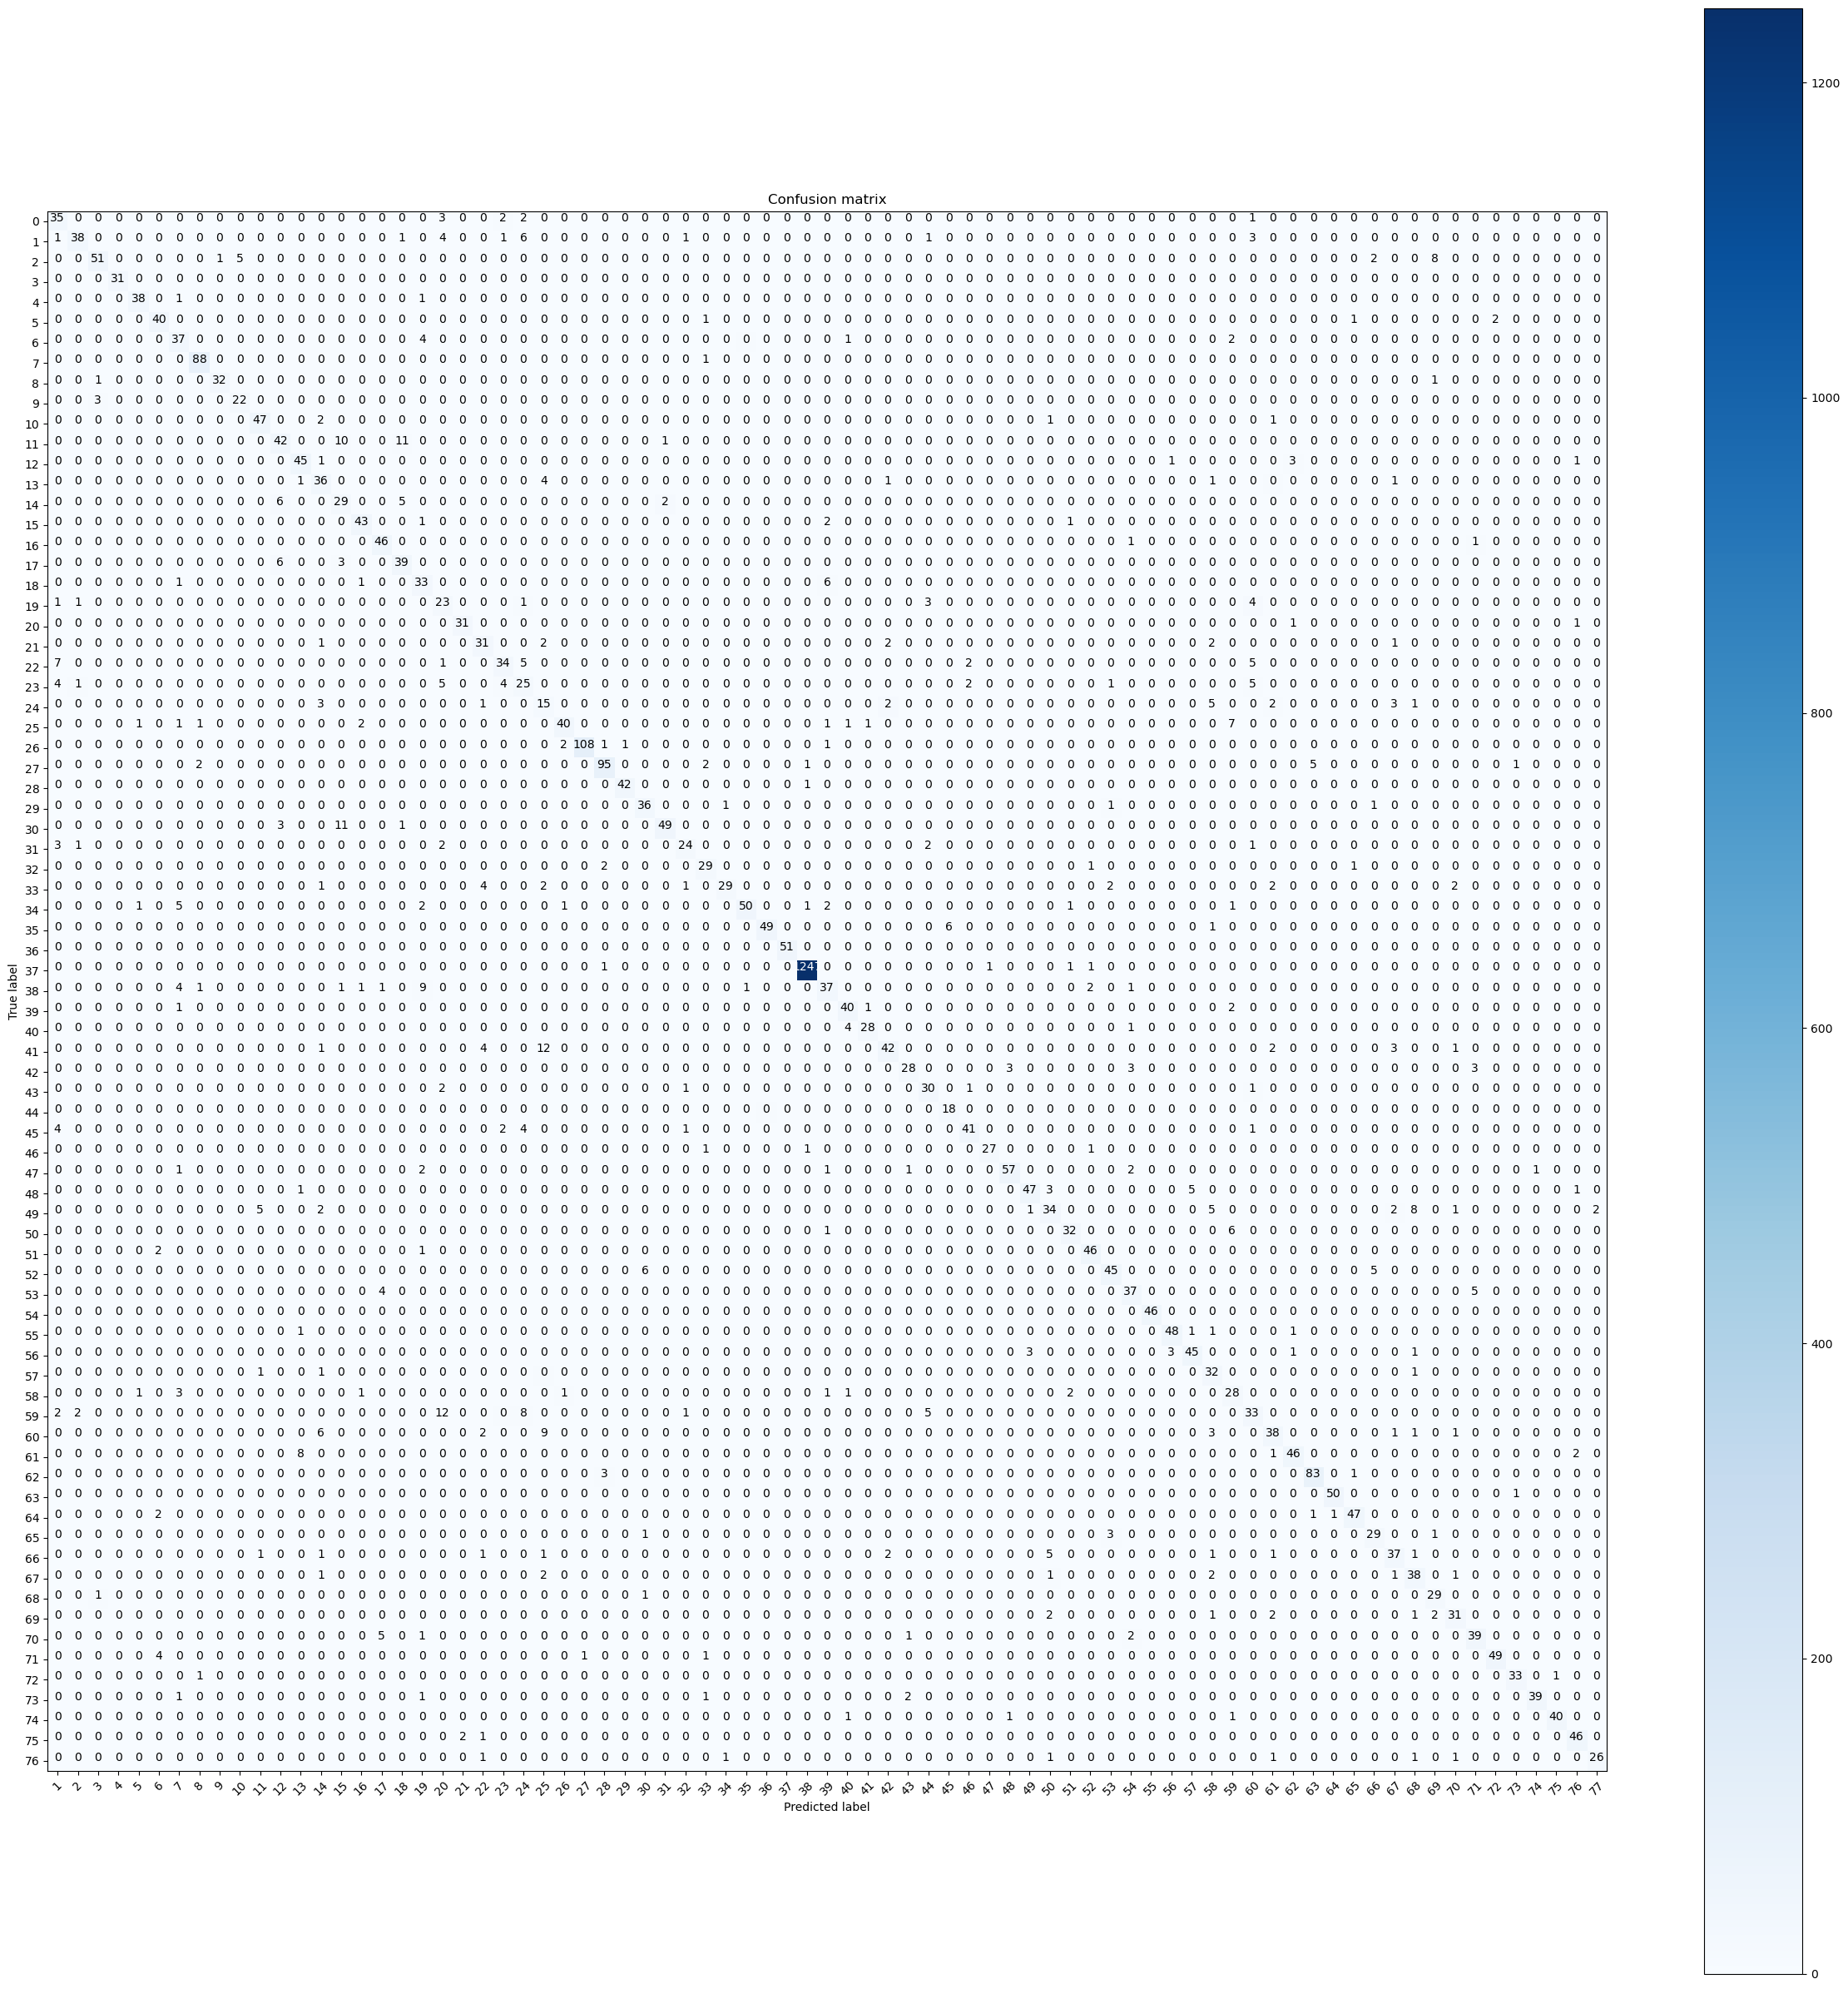

In [34]:
ml.plot_metrics(subcategory_targets, subcategory_predictions, figuresize=(24, 24))